# Flash Method Data Reduction Using ODRPACK 
 (c) Jozef Gembarovic 2015

 ODRPACK (Orthogonal Distance Regression  PACKage) Version 2.1 - see [manual](https://docs.scipy.org/doc/external/odrpack_guide.pdf)

 Import Flash models

In [1]:
from flashmodels3 import *

Populating the interactive namespace from numpy and matplotlib


## Read  Experimental Data from a File

In [2]:
m = np.loadtxt("ss93t.txt", delimiter=" ")
etime= m[:, 0]
etemperature=m[:,1]
pyplot.plot(etime, etemperature)

FileNotFoundError: [Errno 2] No such file or directory: 'ss93t.txt'

### Sample Dimensions

In [75]:
#Stainless steel sample dimensions
# C:\Users\Jozef\Documents\R\R files\Jump Data\1291SSCUShiny\SS93\00301003.fw0
L = 0.1572 #  sample thickness
R = 0.6365 # sample radius
IRI = 0.0 # irradiated radius inner
IRO = 0.5720 # irradiated radius outer
VRI = 0.0 # viewed radius inner
VRO = 0.540 # viewed radius outer

# calculate dimensionless radii
IRID = IRI/R
IROD = IRO/R
VRID = VRI/R
VROD = VRO/R

## Use ODRPACK for Finding Optimal Set of Parameters

In [76]:
# first delete the file 'filename' if it already exist to make room for a new one, generated by the ODRPACK
filename="results2DodrSS93.txt" 
## delete only if file exists ##
if os.path.exists(filename):
    os.remove(filename)
else:
    print("Sorry, I can not remove %s file." % filename)
    
# define analytical function for temperature distribution used by the fitting procedure
def f2DHL(B, x):
    Bio = [B[3], B[3], B[3]*L/R]
    gamas = mroots(funA, Bio, 0.0001, 200) # calculate the first ~ 80 positive roots
    betas = mroots(funR, Bio, 0.0001, 200) 
    return B[0]+B[1]*flash2DHL(x, B[2], L, R, VRID, VROD, IRID, IROD, Bio, gamas, betas) 
    
flash = odrpack.Model(f2DHL) # our model will use 2D model with heat losses

N=40000 #  endpoit index. (N-jump+1) is the number of experimental points to be fitted
jump=200 # jump over the first 200 points after the flash beginning (distorted part)

time=etime[jump:N]
temperature=etemperature[jump:N]

mydata = odrpack.RealData(time, temperature, sx=0.00001, sy=0.0001) # use already simulated data. sx and sy are uncertainties for time and temperature points, resp.

myodr = odrpack.ODR(mydata, flash, beta0=[1.08,4.5, 0.01, 0.02],  # define ODRPACK input parameters - beta0 are initial guess values
                    iprint=6616, rptfile=filename, ifixb=[0,1,1,1] )             # for the baseline level, Beta[0], Tmax, Beta[1], 
                                                                # the thermal diffusivity, Beta[2], and the Biot number, Beta[3] 
                                                    
myoutput = myodr.run() # run Forrest (ODRPACK), run!!
myoutput.pprint() # print a standard simple output

# a more detail report from the ODRPACK is in a freshly created text file "results2DodrSS93.txt"  

Beta: [ 1.08        4.45552698  0.0519272   0.02409936]
Beta Std Error: [  0.00000000e+00   1.71489832e-04   1.74715426e-05   1.05214420e-05]
Beta Covariance: [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.51976391e-12  -9.58009771e-15   5.09368855e-14]
 [  0.00000000e+00  -9.58009771e-15   1.57747280e-14  -7.84436061e-15]
 [  0.00000000e+00   5.09368855e-14  -7.84436061e-15   5.72070969e-15]]
Residual Variance: 19350.8757631
Inverse Condition #: 0.00938950839257
Reason(s) for Halting:
  Sum of squares convergence


## Reconstruct the Response Curve

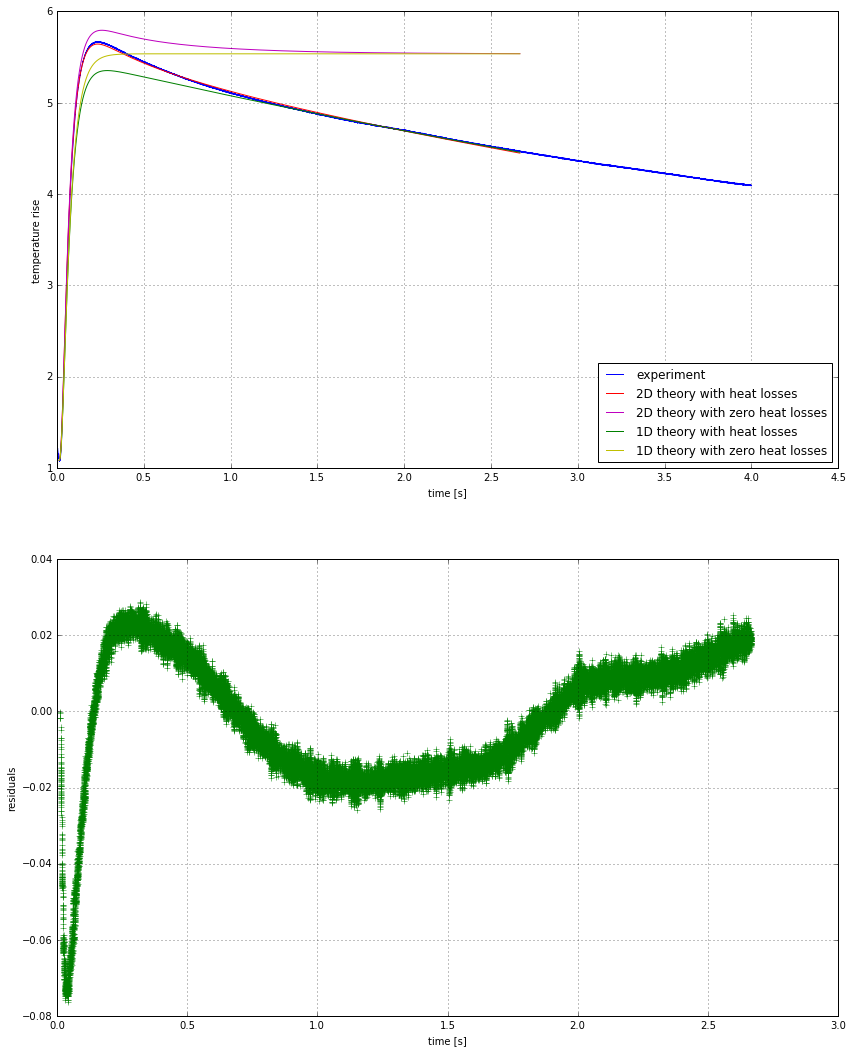

Calculated Optimal Values of [baseline level, Tmax, thermal diffusivity, Biot number] are: 
[ 1.08        4.45552698  0.0519272   0.02409936]

 
 Histogram of residuals


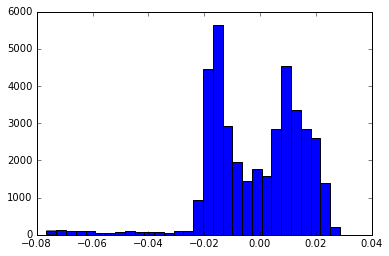

In [78]:
B = myoutput.beta # final results of calculated optimal parameters
Bio=[B[3],B[3],B[3]*L/R]
Bio0=[0.00001, 0.00001, 0.00001]
gamas = mroots(funA, Bio, 0.0001, 200)
betas = mroots(funR, Bio, 0.0001, 200) 

gamas0 = mroots(funA, Bio0, 0.0001, 200)
betas0 = mroots(funR, Bio0, 0.0001, 200) 

time = etime[jump:N]
theory2DHL  = B[0]+B[1]*flash2DHL(time, B[2], L, R, VRID, VROD, IRID, IROD, Bio, gamas, betas) 
theory2DHL0 = B[0]+B[1]*flash2DHL(time, B[2], L, R, VRID, VROD, IRID, IROD, Bio0, gamas0, betas0) 
itheory = B[0]+B[1]*flash1D(time, B[2], L)
theory1DHL = B[0]+B[1]*flash1DHL(time, B[2], L, (B[3],B[3]), gamas)

fig = pyplot.figure(figsize=(14, 18)) 

pyplot.figure(1)
pyplot.subplot(211)
pyplot.plot(etime, etemperature, 'b', label="experiment")
pyplot.plot(time, theory2DHL,'r', label="2D theory with heat losses")
pyplot.plot(time, theory2DHL0,'m', label="2D theory with zero heat losses")
pyplot.plot(time, theory1DHL,'g', label="1D theory with heat losses")
pyplot.plot(time, itheory,'y', label="1D theory with zero heat losses")
pyplot.xlabel("time [s]")
pyplot.ylabel("temperature rise")
pyplot.legend(loc=4)
pyplot.grid()

residuals = temperature - theory2DHL

pyplot.subplot(212)
pyplot.plot(time, residuals, 'g+', label="residuals")
pyplot.xlabel("time [s]")
pyplot.ylabel("residuals")
pyplot.grid()

pyplot.show()

pyplot.hist(residuals, 30) # plot histogram of residuals


print 'Calculated Optimal Values of [baseline level, Tmax, thermal diffusivity, Biot number] are: \n', B
print "\n \n Histogram of residuals"
